# Brent Oil Price Prediction Using RNN

### Project Overview

This project aims to predict the Brent oil price using historical data, incorporating various features such as open, close, high, and low prices, adjusted close, along with additional indicators like returns, log returns, and technical indicators such as moving averages, exponential moving averages, MACD, and RSI. Additionally, crude oil prices (WTI) are included in some feature sets. The prediction model utilizes a Recurrent Neural Network (RNN) architecture trained on four combinations of features: kv1, kv2, kv3, and kv4. Each combination represents a different set of features, ranging from basic price data to a comprehensive mix of technical indicators and crude oil prices. The goal is to develop an accurate forecasting model capable of predicting Brent oil prices based on historical data.

### Import Libraries

In [1]:
# Importing necessary libraries for various tasks

# Utilities
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical computing
import math                      # For mathematical functions
import datetime as dt            # For working with dates and times
from itertools import cycle     # For cycling through iterable objects
from tqdm.notebook import tqdm  # For displaying progress bars in Jupyter notebooks

# Machine Learning
import tensorflow as tf                    # For building and training neural networks
from tensorflow.keras.models import Sequential  # For creating sequential models
from tensorflow.keras.layers import Dense, LSTM, GRU, Activation, Dropout  # For defining neural network layers
from keras.optimizers import Adam         # For configuring optimization algorithms
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score  # For evaluating model performance
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # For scaling data before feeding into the model

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go        # For creating interactive visualizations
import plotly.express as px              # For creating simple and complex plots
from plotly.subplots import make_subplots  # For creating subplots
import plotly.io as pio                  # For configuring plotly settings
pio.renderers.default = "svg"            # Configuring default plotly renderer to be SVG for static plots

import warnings                          # For ignoring warnings during code execution
warnings.filterwarnings('ignore')

### Dataset Input

In [2]:
df = pd.read_excel('./data.xlsx')

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by='Date', inplace=True)

In [4]:
df.shape

(2708, 16)

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Returns,Log Return,5_vol,10_vol,20_vol,SMA_10,EMA_12,MACD,RSI,WTI
0,2012-02-07,428.571472,438.095276,423.809570,428.571472,403.751862,-2.173912,-0.021979,0.014664,0.012363,0.014314,-0.010536,-0.007090,-0.003446,32.631451,98.41
1,2012-02-08,428.571472,433.333374,419.047668,428.571472,403.751862,0.000000,0.000000,0.012022,0.012808,0.013206,-0.009531,-0.005999,-0.003756,32.631451,98.71
2,2012-02-09,423.809570,428.571472,419.047668,423.809570,399.265717,-1.111110,-0.011173,0.012536,0.012817,0.012837,-0.009633,-0.006795,-0.003065,30.130602,99.84
3,2012-02-10,419.047668,423.809570,414.285767,419.047668,394.779602,-1.123595,-0.011300,0.012553,0.012827,0.012839,-0.009737,-0.007488,-0.002479,27.809429,98.67
4,2012-02-13,433.333374,433.333374,414.285767,433.333374,408.237976,3.409088,0.033523,0.021421,0.016535,0.013391,-0.003244,-0.001179,-0.005567,42.068120,100.91


In [6]:
df.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Returns       0
Log Return    0
5_vol         0
10_vol        0
20_vol        0
SMA_10        0
EMA_12        0
MACD          0
RSI           0
WTI           0
dtype: int64

### EDA

In [7]:
# Print the starting date
print("Starting date:", df.iloc[0]['Date'])

# Print the ending date
print("Ending date:", df.iloc[-1]['Date'])

# Print the duration between the starting and ending dates
print("Duration:", df.iloc[-1]['Date'] - df.iloc[0]['Date'])

Starting date: 2012-02-07 00:00:00
Ending date: 2022-12-30 00:00:00
Duration: 3979 days 00:00:00


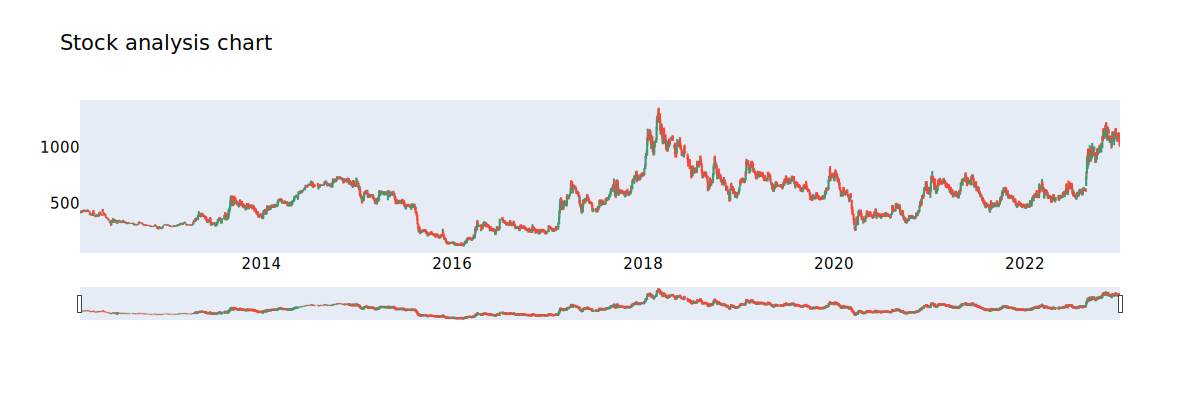

In [8]:
# Creating a candlestick chart for stock analysis
fig = go.Figure()

# Adding candlestick trace to the figure
fig.add_trace(go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick'))

# Updating layout and axis settings
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black', legend_title_text='Stock Parameters', height=400, width=1200)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Displaying the figure
fig.show()

### Feature Combination

Separate by combinations of features

In [9]:
# Extracting relevant features for each key-value pair (kv)
# Key-Value Pair 1 (kv1): Basic stock data with log returns
kv1_features = ['Date', 'Open', 'Close', 'High', 'Low', 'Adj Close', 'Log Return']
kv1 = df[kv1_features]

# Key-Value Pair 2 (kv2): Stock data with technical indicators and log returns
kv2_features = ['Date', 'Close', 'High', 'Low', 'Adj Close', 'SMA_10', 'EMA_12', 'MACD', 'RSI', 'Log Return']
kv2 = df[kv2_features]

# Key-Value Pair 3 (kv3): Stock data with crude oil prices (WTI) and log returns
kv3_features = ['Date', 'Close', 'High', 'Low', 'Adj Close', 'WTI', 'Log Return']
kv3 = df[kv3_features]

# Key-Value Pair 4 (kv4): Stock data with technical indicators, WTI, and log returns
kv4_features = ['Date', 'Close', 'High', 'Low', 'Adj Close', 'SMA_10', 'EMA_12', 'MACD', 'RSI', 'WTI', 'Log Return']
kv4 = df[kv4_features]

### KV1

#### Preparation

In [10]:
# Train test split with ratio
ratio = 0.2

# Extract the 'Date' column
kv1_date = kv1[['Date']]

# Calculate the size of the training set
train_size = int((1 - ratio) * len(kv1))

# Split the data into training and testing sets
kv1_train = kv1.iloc[:train_size, 1:]  # Exclude the 'Date' column from the training data
kv1_test = kv1.iloc[train_size:, 1:]   # Exclude the 'Date' column from the testing data

# Print the training data
print("Training data:")
print(kv1_train)

# Print the testing data
print("\nTesting data:")
print(kv1_test)

Training data:
            Open       Close        High         Low   Adj Close  Log Return
0     428.571472  428.571472  438.095276  423.809570  403.751862   -0.021979
1     428.571472  428.571472  433.333374  419.047668  403.751862    0.000000
2     423.809570  423.809570  428.571472  419.047668  399.265717   -0.011173
3     419.047668  419.047668  423.809570  414.285767  394.779602   -0.011300
4     433.333374  433.333374  433.333374  414.285767  408.237976    0.033523
...          ...         ...         ...         ...         ...         ...
2161  348.000000  346.000000  354.000000  344.000000  325.964111    0.000000
2162  348.000000  354.000000  362.000000  348.000000  333.500885    0.022858
2163  358.000000  354.000000  360.000000  352.000000  333.500885    0.000000
2164  352.000000  352.000000  356.000000  344.000000  331.616699   -0.005666
2165  354.000000  380.000000  380.000000  352.000000  357.995300    0.076540

[2166 rows x 6 columns]

Testing data:
        Open   Close 

In [11]:
# Initialize the StandardScaler
sc = StandardScaler()

# Scale the training data
kv1_train_scaled = sc.fit_transform(kv1_train)

# Print the shape of the scaled training data
print("Shape of scaled training data:", kv1_train_scaled.shape)

Shape of scaled training data: (2166, 6)


In [12]:
# Initialize the StandardScaler
sc2 = StandardScaler()

# Scale the 'Adj Close' column of the training data
kv1_train_scaled_y = sc2.fit_transform(kv1_train[['Adj Close']])

# Print the shape of the scaled 'Adj Close' column
print("Shape of scaled 'Adj Close' column:", kv1_train_scaled_y.shape)

Shape of scaled 'Adj Close' column: (2166, 1)


In [13]:
# Define the number of time steps (hops)
hops = 14

# Calculate the number of records in the training data after applying the ratio
no_records = len(df) - int((ratio) * len(df))

# Initialize empty lists to store the feature sequences (X_train) and target values (y_train)
X_train = []
y_train = []

# Ensure that the loop iterates within the bounds of the data
for i in range(hops, no_records):
    # Append the scaled feature sequences of length 'hops' to X_train
    X_train.append(kv1_train_scaled[i - hops:i])
    # Ensure that the index is within the bounds of kv1_train_scaled_y
    if i < len(kv1_train_scaled_y):
        # Append the scaled target values to y_train
        y_train.append(kv1_train_scaled_y[i])

# Convert the lists to numpy arrays for model training
X_train, y_train = np.array(X_train), np.array(y_train)

# Trim X_train to match the length of y_train
X_train = X_train[:len(y_train)]

In [14]:
# Reshape X_train to maintain its original shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_train_reshaped.shape

(2152, 14, 6)

In [15]:
y_train.shape

(2152, 1)

#### Build Model

In [16]:
# Define the model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(hops, 6)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Training Model

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2648 - val_loss: 0.0160
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0323 - val_loss: 0.0117
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0250 - val_loss: 0.0110
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - val_loss: 0.0111
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - val_loss: 0.0100
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - val_loss: 0.0093
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0154 - val_loss: 0.0091
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - val_loss: 0.0092
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 - val_loss: 0.0107
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0187 - val_loss: 0.0174
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0218 - val_loss: 0.0118
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0

#### Testing

In [18]:
# Concatenate the last 14 records from the training set with the full test set for evaluation
kv1_train_last14 = kv1_train.iloc[-hops:]
kv1_test_full = kv1_test
full_df = pd.concat((kv1_train_last14, kv1_test_full), axis=0)

# Print the shape and first few rows of the concatenated dataframe
print(full_df.shape)
full_df.head()

(556, 6)


,Open,Close,High,Low,Adj Close,Log Return
2152,360.0,372.0,376.0,360.0,350.458557,0.032790
2153,374.0,364.0,380.0,362.0,342.921814,-0.021740
2154,364.0,348.0,370.0,346.0,327.848328,-0.044951
2155,344.0,338.0,358.0,336.0,318.427399,-0.029157
2156,340.0,354.0,356.0,340.0,333.500885,0.046251


In [19]:
# Rescale the test pandas dataframe using the previously fitted StandardScaler object 'sc'
full_df = sc.transform(full_df)

# Check the shape of the rescaled dataframe
full_df.shape

(556, 6)

In [20]:
# Reshape the test pandas dataframe into sequences for prediction
X_train_shape_pred = []
# Iterate through the test dataframe to create sequences for prediction
for i in range(hops, 555):
    # Append the feature sequences of length 'hops' to X_train_shape_pred
    X_train_shape_pred.append(full_df[i - hops:i])
# Convert the list of sequences to a numpy array
X_train_shape_pred = np.array(X_train_shape_pred)

# Check the shape of the reshaped test data
print(X_train_shape_pred.shape)

(541, 14, 6)


In [21]:
# Predict the target values for the test data
y_test_pred = model.predict(X_train_shape_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [22]:
# Inverse transform the predicted target values to their original scale
y_final_pred = sc2.inverse_transform(y_test_pred)

In [23]:
# Convert the predicted log returns back to the scale of the 'Adj Close' column
final_adj_close_pred = pd.DataFrame(y_final_pred)
final_adj_close_pred.columns = ['Final Adj Close Pred']
final_adj_close_pred

,Final Adj Close Pred
0,364.076172
1,367.497711
2,363.734192
3,369.178375
4,362.719879
...,...
536,1064.209473
537,1058.047974
538,1060.537842
539,1041.883301


In [24]:
# Concatenate the final predicted adjusted close values with the original test data
fully_final = pd.concat((final_adj_close_pred, kv1_test.reset_index()), axis=1)
# Select relevant columns for the final dataframe
fully_final = fully_final[['Open', 'Close', 'High', 'Low', 'Adj Close', 'Final Adj Close Pred']]
fully_final

,Open,Close,High,Low,Adj Close,Final Adj Close Pred
0,390.0,382.0,398.0,380.0,359.879486,364.076172
1,384.0,380.0,388.0,376.0,357.995300,367.497711
2,384.0,386.0,394.0,378.0,363.647858,363.734192
3,386.0,380.0,388.0,376.0,357.995300,369.178375
4,382.0,374.0,386.0,372.0,352.342743,362.719879
...,...,...,...,...,...,...
537,1120.0,1110.0,1135.0,1100.0,1110.000000,1058.047974
538,1115.0,1085.0,1125.0,1080.0,1085.000000,1060.537842
539,1095.0,1055.0,1100.0,1050.0,1055.000000,1041.883301
540,1050.0,1030.0,1050.0,1020.0,1030.000000,1018.756714


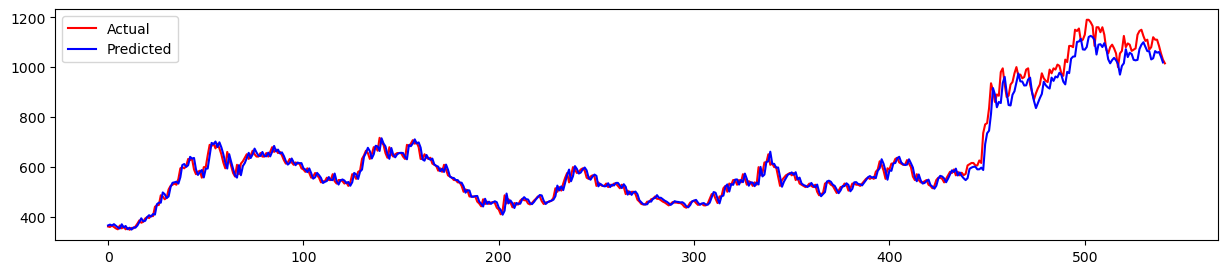

In [25]:
# Plot the actual and predicted log return values
plt.figure(figsize=(15, 3))  # Adjust the width and height as needed
plt.plot(fully_final['Adj Close'], label='Actual', color='red')
plt.plot(fully_final['Final Adj Close Pred'], label='Predicted', color='blue')
plt.legend()
plt.show()

#### Evaluation

In [26]:
# Drop rows with missing values
fully_final.dropna(inplace=True)

# Evaluation
import sklearn.metrics as metrics

y = fully_final['Adj Close']
yhat = fully_final['Final Adj Close Pred']
mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse)  # or mse**(0.5)
r2 = metrics.r2_score(y, yhat)

print("Results of sklearn.metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 20.08321714841945
MSE: 865.3460577067569
RMSE: 29.416764908921525
R-Squared: 0.9784035438882397


### KV2

#### Preparation

In [27]:
# Train test split with ratio
ratio = 0.2

# Extract the 'Date' column
kv2_date = kv2[['Date']]

# Calculate the size of the training set
train_size = int((1 - ratio) * len(kv2))

# Split the data into training and testing sets
kv2_train = kv2.iloc[:train_size, 1:]  # Exclude the 'Date' column from the training data
kv2_test = kv2.iloc[train_size:, 1:]   # Exclude the 'Date' column from the testing data

# Print the training data
print("Training data:")
print(kv2_train)

# Print the testing data
print("\nTesting data:")
print(kv2_test)

Training data:
           Close        High         Low   Adj Close    SMA_10    EMA_12  \
0     428.571472  438.095276  423.809570  403.751862 -0.010536 -0.007090   
1     428.571472  433.333374  419.047668  403.751862 -0.009531 -0.005999   
2     423.809570  428.571472  419.047668  399.265717 -0.009633 -0.006795   
3     419.047668  423.809570  414.285767  394.779602 -0.009737 -0.007488   
4     433.333374  433.333374  414.285767  408.237976 -0.003244 -0.001179   
...          ...         ...         ...         ...       ...       ...   
2161  346.000000  354.000000  344.000000  325.964111 -0.003967 -0.006159   
2162  354.000000  362.000000  348.000000  333.500885 -0.004960 -0.001695   
2163  354.000000  360.000000  352.000000  333.500885 -0.002786 -0.001434   
2164  352.000000  356.000000  344.000000  331.616699  0.001143 -0.002085   
2165  380.000000  380.000000  352.000000  357.995300  0.011713  0.010011   

          MACD        RSI  Log Return  
0    -0.003446  32.631451   -0.0

In [28]:
# Initialize the StandardScaler
sc = StandardScaler()

# Scale the training data
kv2_train_scaled = sc.fit_transform(kv2_train)

# Print the shape of the scaled training data
print("Shape of scaled training data:", kv2_train_scaled.shape)

Shape of scaled training data: (2166, 9)


In [29]:
# Initialize the StandardScaler
sc2 = StandardScaler()

# Scale the 'Adj Close' column of the training data
kv2_train_scaled_y = sc2.fit_transform(kv2_train[['Adj Close']])

# Print the shape of the scaled 'Adj Close' column
print("Shape of scaled 'Adj Close' column:", kv2_train_scaled_y.shape)

Shape of scaled 'Adj Close' column: (2166, 1)


In [30]:
# Define the number of time steps (hops)
hops = 14

# Calculate the number of records in the training data after applying the ratio
no_records = len(kv2) - int((ratio) * len(kv2))

# Initialize empty lists to store the feature sequences (X_train) and target values (y_train)
X_train = []
y_train = []

# Ensure that the loop iterates within the bounds of the data
for i in range(hops, no_records):
    # Append the scaled feature sequences of length 'hops' to X_train
    X_train.append(kv2_train_scaled[i - hops:i])
    # Ensure that the index is within the bounds of kv2_train_scaled_y
    if i < len(kv2_train_scaled_y):
        # Append the scaled target values to y_train
        y_train.append(kv2_train_scaled_y[i])

# Convert the lists to numpy arrays for model training
X_train, y_train = np.array(X_train), np.array(y_train)

# Trim X_train to match the length of y_train
X_train = X_train[:len(y_train)]

In [31]:
# Reshape X_train to maintain its original shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_train_reshaped.shape

(2152, 14, 9)

In [32]:
y_train.shape

(2152, 1)

#### Build Model

In [33]:
# Define the model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(hops, 9)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Training Model

In [34]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.3693 - val_loss: 0.0266
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0376 - val_loss: 0.0147
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0264 - val_loss: 0.0133
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238 - val_loss: 0.0146
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0226 - val_loss: 0.0146
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0233 - val_loss: 0.0105
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0196 - val_loss: 0.0130
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0219 - val_loss: 0.0101
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0200 - val_loss: 0.0111
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0168 - val_loss: 0.0110
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0187 - val_loss: 0.0103
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step -

#### Testing

In [35]:
# Concatenate the last 14 records from the training set with the full test set for evaluation
kv2_train_last14 = kv2_train.iloc[-hops:]
kv2_test_full = kv2_test
full_df = pd.concat((kv2_train_last14, kv2_test_full), axis=0)

# Print the shape and first few rows of the concatenated dataframe
print(full_df.shape)
full_df.head()

(556, 9)


,Close,High,Low,Adj Close,SMA_10,EMA_12,MACD,RSI,Log Return
2152,372.0,376.0,360.0,350.458557,-0.011659,-0.013182,0.004124,36.009443,0.032790
2153,364.0,380.0,362.0,342.921814,-0.011900,-0.014498,0.004502,34.189683,-0.021740
2154,348.0,370.0,346.0,327.848328,-0.014425,-0.019183,0.006597,30.731487,-0.044951
2155,338.0,358.0,336.0,318.427399,-0.021244,-0.020718,0.006904,28.703490,-0.029157
2156,354.0,356.0,340.0,333.500885,-0.017096,-0.010415,0.001051,35.926701,0.046251


In [36]:
# Rescale the test pandas dataframe using the previously fitted StandardScaler object 'sc'
full_df = sc.transform(full_df)

# Check the shape of the rescaled dataframe
full_df.shape

(556, 9)

In [37]:
# Reshape the test pandas dataframe into sequences for prediction
X_train_shape_pred = []
# Iterate through the test dataframe to create sequences for prediction
for i in range(hops, 555):
    # Append the feature sequences of length 'hops' to X_train_shape_pred
    X_train_shape_pred.append(full_df[i - hops:i])
# Convert the list of sequences to a numpy array
X_train_shape_pred = np.array(X_train_shape_pred)

# Check the shape of the reshaped test data
print(X_train_shape_pred.shape)

(541, 14, 9)


In [38]:
# Predict the target values for the test data
y_test_pred = model.predict(X_train_shape_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [39]:
# Inverse transform the predicted target values to their original scale
y_final_pred = sc2.inverse_transform(y_test_pred)

In [40]:
# Convert the predicted log returns back to the scale of the 'Adj Close' column
final_adj_close_pred = pd.DataFrame(y_final_pred)
final_adj_close_pred.columns = ['Final Adj Close Pred']
final_adj_close_pred

,Final Adj Close Pred
0,360.019287
1,363.027954
2,359.278442
3,362.593170
4,355.770264
...,...
536,1049.680176
537,1039.822510
538,1041.374023
539,1024.487549


In [41]:
# Concatenate the final predicted adjusted close values with the original test data
fully_final = pd.concat((final_adj_close_pred, kv2_test.reset_index()), axis=1)
# Select relevant columns for the final dataframe
fully_final = fully_final[['Close', 'High', 'Low', 'Adj Close', 'SMA_10', 'EMA_12', 'MACD', 'RSI', 'Log Return', 'Final Adj Close Pred']]
fully_final

,Close,High,Low,Adj Close,SMA_10,EMA_12,MACD,RSI,Log Return,Final Adj Close Pred
0,382.0,398.0,380.0,359.879486,0.007612,0.009279,-0.007894,52.067612,0.005249,360.019287
1,380.0,388.0,376.0,357.995300,0.011713,0.007043,-0.006150,51.321147,-0.005249,363.027954
2,386.0,394.0,378.0,363.647858,0.013279,0.008370,-0.006383,53.465313,0.015666,359.278442
3,380.0,388.0,376.0,357.995300,0.006524,0.004672,-0.003992,51.044019,-0.015666,362.593170
4,374.0,386.0,372.0,352.342743,0.007782,0.001505,-0.002054,48.634330,-0.015915,355.770264
...,...,...,...,...,...,...,...,...,...,...
537,1110.0,1135.0,1100.0,1110.000000,-0.001786,0.001013,-0.000097,52.328734,0.000000,1039.822510
538,1085.0,1125.0,1080.0,1085.000000,-0.005382,-0.002647,0.001808,48.116697,-0.022780,1041.374023
539,1055.0,1100.0,1050.0,1055.000000,-0.008622,-0.006554,0.003700,43.477789,-0.028039,1024.487549
540,1030.0,1050.0,1020.0,1030.000000,-0.008822,-0.009235,0.004816,39.931762,-0.023982,1002.081604


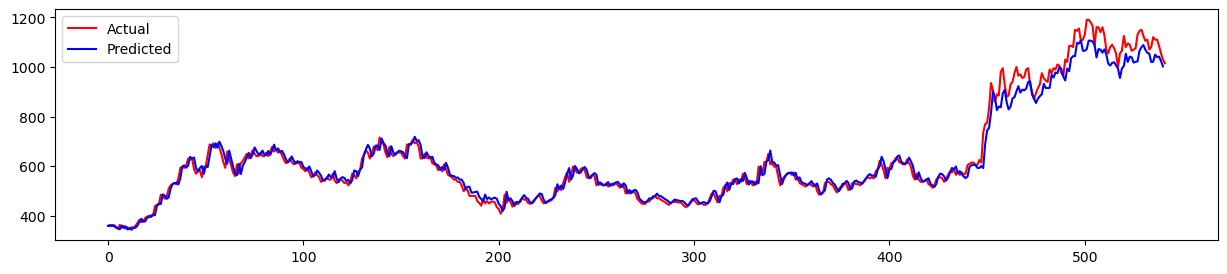

In [42]:
# Plot the actual and predicted log return values
plt.figure(figsize=(15, 3))  # Adjust the width and height as needed
plt.plot(fully_final['Adj Close'], label='Actual', color='red')
plt.plot(fully_final['Final Adj Close Pred'], label='Predicted', color='blue')
plt.legend()
plt.show()

#### Evaluation

In [43]:
# Drop rows with missing values
fully_final.dropna(inplace=True)

# Evaluation
import sklearn.metrics as metrics

y = fully_final['Adj Close']
yhat = fully_final['Final Adj Close Pred']
mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse)  # or mse**(0.5)
r2 = metrics.r2_score(y, yhat)

print("Results of sklearn.metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 22.21754057878928
MSE: 1056.4476054544093
RMSE: 32.50303994174098
R-Squared: 0.9736342193479987


### KV3

#### Preparation

In [44]:
# Train test split with ratio
ratio = 0.2

# Extract the 'Date' column
kv3_date = kv3[['Date']]

# Calculate the size of the training set
train_size = int((1 - ratio) * len(kv3))

# Split the data into training and testing sets
kv3_train = kv3.iloc[:train_size, 1:]  # Exclude the 'Date' column from the training data
kv3_test = kv3.iloc[train_size:, 1:]   # Exclude the 'Date' column from the testing data

# Print the training data
print("Training data:")
print(kv3_train)

# Print the testing data
print("\nTesting data:")
print(kv3_test)

Training data:
           Close        High         Low   Adj Close     WTI  Log Return
0     428.571472  438.095276  423.809570  403.751862   98.41   -0.021979
1     428.571472  433.333374  419.047668  403.751862   98.71    0.000000
2     423.809570  428.571472  419.047668  399.265717   99.84   -0.011173
3     419.047668  423.809570  414.285767  394.779602   98.67   -0.011300
4     433.333374  433.333374  414.285767  408.237976  100.91    0.033523
...          ...         ...         ...         ...     ...         ...
2161  346.000000  354.000000  344.000000  325.964111   41.19    0.000000
2162  354.000000  362.000000  348.000000  333.500885   40.60    0.022858
2163  354.000000  360.000000  352.000000  333.500885   39.43    0.000000
2164  352.000000  356.000000  344.000000  331.616699   40.20   -0.005666
2165  380.000000  380.000000  352.000000  357.995300   41.04    0.076540

[2166 rows x 6 columns]

Testing data:
       Close    High     Low    Adj Close    WTI  Log Return
2166   3

In [45]:
# Initialize the StandardScaler
sc = StandardScaler()

# Scale the training data
kv3_train_scaled = sc.fit_transform(kv3_train)

# Print the shape of the scaled training data
print("Shape of scaled training data:", kv3_train_scaled.shape)

Shape of scaled training data: (2166, 6)


In [46]:
# Initialize the StandardScaler
sc2 = StandardScaler()

# Scale the 'Adj Close' column of the training data
kv3_train_scaled_y = sc2.fit_transform(kv3_train[['Adj Close']])

# Print the shape of the scaled 'Adj Close' column
print("Shape of scaled 'Adj Close' column:", kv3_train_scaled_y.shape)

Shape of scaled 'Adj Close' column: (2166, 1)


In [47]:
# Define the number of time steps (hops)
hops = 14

# Calculate the number of records in the training data after applying the ratio
no_records = len(df) - int((ratio) * len(df))

# Initialize empty lists to store the feature sequences (X_train) and target values (y_train)
X_train = []
y_train = []

# Ensure that the loop iterates within the bounds of the data
for i in range(hops, no_records):
    # Append the scaled feature sequences of length 'hops' to X_train
    X_train.append(kv3_train_scaled[i - hops:i])
    # Ensure that the index is within the bounds of kv3_train_scaled_y
    if i < len(kv3_train_scaled_y):
        # Append the scaled target values to y_train
        y_train.append(kv3_train_scaled_y[i])

# Convert the lists to numpy arrays for model training
X_train, y_train = np.array(X_train), np.array(y_train)

# Trim X_train to match the length of y_train
X_train = X_train[:len(y_train)]

In [48]:
# Reshape X_train to maintain its original shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_train_reshaped.shape

(2152, 14, 6)

In [49]:
y_train.shape

(2152, 1)

#### Build Model

In [50]:
# Define the model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(hops, 6)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Training Model

In [51]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.3437 - val_loss: 0.0189
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0382 - val_loss: 0.0133
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0248 - val_loss: 0.0137
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0205 - val_loss: 0.0110
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0191 - val_loss: 0.0100
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0164 - val_loss: 0.0119
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0168 - val_loss: 0.0126
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0191 - val_loss: 0.0183
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0176 - val_loss: 0.0092
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0161 - val_loss: 0.0106
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0161 - val_loss: 0.0102
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - 

#### Testing

In [52]:
# Concatenate the last 14 records from the training set with the full test set for evaluation
kv3_train_last14 = kv3_train.iloc[-hops:]
kv3_test_full = kv3_test
full_df = pd.concat((kv3_train_last14, kv3_test_full), axis=0)

# Print the shape and first few rows of the concatenated dataframe
print(full_df.shape)
full_df.head()

(556, 6)


,Close,High,Low,Adj Close,WTI,Log Return
2152,372.0,376.0,360.0,350.458557,40.25,0.032790
2153,364.0,380.0,362.0,342.921814,40.60,-0.021740
2154,348.0,370.0,346.0,327.848328,39.29,-0.044951
2155,338.0,358.0,336.0,318.427399,40.22,-0.029157
2156,354.0,356.0,340.0,333.500885,38.72,0.046251


In [53]:
# Rescale the test pandas dataframe using the previously fitted StandardScaler object 'sc'
full_df = sc.transform(full_df)

# Check the shape of the rescaled dataframe
full_df.shape

(556, 6)

In [54]:
# Reshape the test pandas dataframe into sequences for prediction
X_train_shape_pred = []
# Iterate through the test dataframe to create sequences for prediction
for i in range(hops, 555):
    # Append the feature sequences of length 'hops' to X_train_shape_pred
    X_train_shape_pred.append(full_df[i - hops:i])
# Convert the list of sequences to a numpy array
X_train_shape_pred = np.array(X_train_shape_pred)

# Check the shape of the reshaped test data
print(X_train_shape_pred.shape)

(541, 14, 6)


In [55]:
# Predict the target values for the test data
y_test_pred = model.predict(X_train_shape_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [56]:
# Inverse transform the predicted target values to their original scale
y_final_pred = sc2.inverse_transform(y_test_pred)

In [57]:
# Convert the predicted log returns back to the scale of the 'Adj Close' column
final_adj_close_pred = pd.DataFrame(y_final_pred)
final_adj_close_pred.columns = ['Final Adj Close Pred']
final_adj_close_pred

,Final Adj Close Pred
0,348.736389
1,352.542236
2,349.141571
3,354.361969
4,349.080872
...,...
536,1004.797058
537,996.104675
538,997.974976
539,984.337219


In [58]:
# Concatenate the final predicted adjusted close values with the original test data
fully_final = pd.concat((final_adj_close_pred, kv3_test.reset_index()), axis=1)
# Select relevant columns for the final dataframe
fully_final = fully_final[['Close', 'High', 'Low', 'Adj Close', 'WTI', 'Log Return', 'Final Adj Close Pred']]
fully_final

,Close,High,Low,Adj Close,WTI,Log Return,Final Adj Close Pred
0,382.0,398.0,380.0,359.879486,40.96,0.005249,348.736389
1,380.0,388.0,376.0,357.995300,40.88,-0.005249,352.542236
2,386.0,394.0,378.0,363.647858,40.83,0.015666,349.141571
3,380.0,388.0,376.0,357.995300,41.46,-0.015666,354.361969
4,374.0,386.0,372.0,352.342743,40.03,-0.015915,349.080872
...,...,...,...,...,...,...,...
537,1110.0,1135.0,1100.0,1110.000000,80.97,0.000000,996.104675
538,1085.0,1125.0,1080.0,1085.000000,79.77,-0.022780,997.974976
539,1055.0,1100.0,1050.0,1055.000000,78.60,-0.028039,984.337219
540,1030.0,1050.0,1020.0,1030.000000,78.61,-0.023982,968.774231


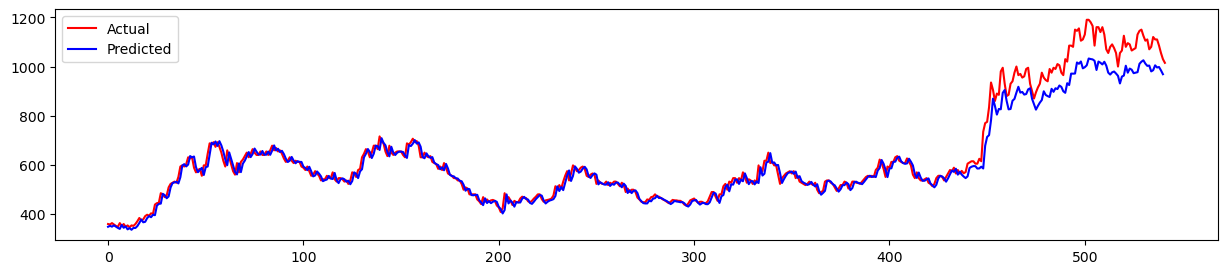

In [59]:
# Plot the actual and predicted log return values
plt.figure(figsize=(15, 3))  # Adjust the width and height as needed
plt.plot(fully_final['Adj Close'], label='Actual', color='red')
plt.plot(fully_final['Final Adj Close Pred'], label='Predicted', color='blue')
plt.legend()
plt.show()

#### Evaluation

In [60]:
# Drop rows with missing values
fully_final.dropna(inplace=True)

# Evaluation
import sklearn.metrics as metrics

y = fully_final['Adj Close']
yhat = fully_final['Final Adj Close Pred']
mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse)  # or mse**(0.5)
r2 = metrics.r2_score(y, yhat)

print("Results of sklearn.metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 28.376590580684642
MSE: 2153.49290234919
RMSE: 46.405742126909146
R-Squared: 0.946255241428127


### KV4

#### Preparation

In [61]:
# Train test split with ratio
ratio = 0.2

# Extract the 'Date' column
kv4_date = kv4[['Date']]

# Calculate the size of the training set
train_size = int((1 - ratio) * len(kv4))

# Split the data into training and testing sets
kv4_train = kv4.iloc[:train_size, 1:]  # Exclude the 'Date' column from the training data
kv4_test = kv4.iloc[train_size:, 1:]   # Exclude the 'Date' column from the testing data

# Print the training data
print("Training data:")
print(kv4_train)

# Print the testing data
print("\nTesting data:")
print(kv4_test)

Training data:
           Close        High         Low   Adj Close    SMA_10    EMA_12  \
0     428.571472  438.095276  423.809570  403.751862 -0.010536 -0.007090   
1     428.571472  433.333374  419.047668  403.751862 -0.009531 -0.005999   
2     423.809570  428.571472  419.047668  399.265717 -0.009633 -0.006795   
3     419.047668  423.809570  414.285767  394.779602 -0.009737 -0.007488   
4     433.333374  433.333374  414.285767  408.237976 -0.003244 -0.001179   
...          ...         ...         ...         ...       ...       ...   
2161  346.000000  354.000000  344.000000  325.964111 -0.003967 -0.006159   
2162  354.000000  362.000000  348.000000  333.500885 -0.004960 -0.001695   
2163  354.000000  360.000000  352.000000  333.500885 -0.002786 -0.001434   
2164  352.000000  356.000000  344.000000  331.616699  0.001143 -0.002085   
2165  380.000000  380.000000  352.000000  357.995300  0.011713  0.010011   

          MACD        RSI     WTI  Log Return  
0    -0.003446  32.63145

In [62]:
# Initialize the StandardScaler
sc = StandardScaler()

# Scale the training data
kv4_train_scaled = sc.fit_transform(kv4_train)

# Print the shape of the scaled training data
print("Shape of scaled training data:", kv4_train_scaled.shape)

Shape of scaled training data: (2166, 10)


In [63]:
# Initialize the StandardScaler
sc2 = StandardScaler()

# Scale the 'Adj Close' column of the training data
kv4_train_scaled_y = sc2.fit_transform(kv4_train[['Adj Close']])

# Print the shape of the scaled 'Adj Close' column
print("Shape of scaled 'Adj Close' column:", kv4_train_scaled_y.shape)

Shape of scaled 'Adj Close' column: (2166, 1)


In [64]:
# Define the number of time steps (hops)
hops = 14

# Calculate the number of records in the training data after applying the ratio
no_records = len(df) - int((ratio) * len(df))

# Initialize empty lists to store the feature sequences (X_train) and target values (y_train)
X_train = []
y_train = []

# Ensure that the loop iterates within the bounds of the data
for i in range(hops, no_records):
    # Append the scaled feature sequences of length 'hops' to X_train
    X_train.append(kv4_train_scaled[i - hops:i])
    # Ensure that the index is within the bounds of kv4_train_scaled_y
    if i < len(kv4_train_scaled_y):
        # Append the scaled target values to y_train
        y_train.append(kv4_train_scaled_y[i])

# Convert the lists to numpy arrays for model training
X_train, y_train = np.array(X_train), np.array(y_train)

# Trim X_train to match the length of y_train
X_train = X_train[:len(y_train)]

In [65]:
# Reshape X_train to maintain its original shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_train_reshaped.shape

(2152, 14, 10)

In [66]:
y_train.shape

(2152, 1)

#### Build Model

In [67]:
# Define the model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(hops, 10)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Training Model

In [68]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2106 - val_loss: 0.0455
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0348 - val_loss: 0.0177
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0230 - val_loss: 0.0120
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0226 - val_loss: 0.0130
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0207 - val_loss: 0.0108
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0215 - val_loss: 0.0110
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0178 - val_loss: 0.0098
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0188 - val_loss: 0.0096
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0180 - val_loss: 0.0125
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0169 - val_loss: 0.0139
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0169 - val_loss: 0.0093
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - los

#### Testing

In [69]:
# Concatenate the last 14 records from the training set with the full test set for evaluation
kv4_train_last14 = kv4_train.iloc[-hops:]
kv4_test_full = kv4_test
full_df = pd.concat((kv4_train_last14, kv4_test_full), axis=0)

# Print the shape and first few rows of the concatenated dataframe
print(full_df.shape)
full_df.head()

(556, 10)


,Close,High,Low,Adj Close,SMA_10,EMA_12,MACD,RSI,WTI,Log Return
2152,372.0,376.0,360.0,350.458557,-0.011659,-0.013182,0.004124,36.009443,40.25,0.032790
2153,364.0,380.0,362.0,342.921814,-0.011900,-0.014498,0.004502,34.189683,40.60,-0.021740
2154,348.0,370.0,346.0,327.848328,-0.014425,-0.019183,0.006597,30.731487,39.29,-0.044951
2155,338.0,358.0,336.0,318.427399,-0.021244,-0.020718,0.006904,28.703490,40.22,-0.029157
2156,354.0,356.0,340.0,333.500885,-0.017096,-0.010415,0.001051,35.926701,38.72,0.046251


In [70]:
# Rescale the test pandas dataframe using the previously fitted StandardScaler object 'sc'
full_df = sc.transform(full_df)

# Check the shape of the rescaled dataframe
full_df.shape

(556, 10)

In [71]:
# Reshape the test pandas dataframe into sequences for prediction
X_train_shape_pred = []
# Iterate through the test dataframe to create sequences for prediction
for i in range(hops, 555):
    # Append the feature sequences of length 'hops' to X_train_shape_pred
    X_train_shape_pred.append(full_df[i - hops:i])
# Convert the list of sequences to a numpy array
X_train_shape_pred = np.array(X_train_shape_pred)

# Check the shape of the reshaped test data
print(X_train_shape_pred.shape)

(541, 14, 10)


In [72]:
# Predict the target values for the test data
y_test_pred = model.predict(X_train_shape_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [73]:
# Inverse transform the predicted target values to their original scale
y_final_pred = sc2.inverse_transform(y_test_pred)

In [74]:
# Convert the predicted log returns back to the scale of the 'Adj Close' column
final_adj_close_pred = pd.DataFrame(y_final_pred)
final_adj_close_pred.columns = ['Final Adj Close Pred']
final_adj_close_pred

,Final Adj Close Pred
0,352.774231
1,356.704132
2,354.142426
3,359.025208
4,353.123657
...,...
536,1021.808899
537,1013.275635
538,1015.184631
539,1001.016113


In [75]:
# Concatenate the final predicted adjusted close values with the original test data
fully_final = pd.concat((final_adj_close_pred, kv4_test.reset_index()), axis=1)
# Select relevant columns for the final dataframe
fully_final = fully_final[['Close', 'High', 'Low', 'Adj Close', 'SMA_10', 'EMA_12', 'MACD', 'RSI', 'WTI', 'Log Return', 'Final Adj Close Pred']]
fully_final

,Close,High,Low,Adj Close,SMA_10,EMA_12,MACD,RSI,WTI,Log Return,Final Adj Close Pred
0,382.0,398.0,380.0,359.879486,0.007612,0.009279,-0.007894,52.067612,40.96,0.005249,352.774231
1,380.0,388.0,376.0,357.995300,0.011713,0.007043,-0.006150,51.321147,40.88,-0.005249,356.704132
2,386.0,394.0,378.0,363.647858,0.013279,0.008370,-0.006383,53.465313,40.83,0.015666,354.142426
3,380.0,388.0,376.0,357.995300,0.006524,0.004672,-0.003992,51.044019,41.46,-0.015666,359.025208
4,374.0,386.0,372.0,352.342743,0.007782,0.001505,-0.002054,48.634330,40.03,-0.015915,353.123657
...,...,...,...,...,...,...,...,...,...,...,...
537,1110.0,1135.0,1100.0,1110.000000,-0.001786,0.001013,-0.000097,52.328734,80.97,0.000000,1013.275635
538,1085.0,1125.0,1080.0,1085.000000,-0.005382,-0.002647,0.001808,48.116697,79.77,-0.022780,1015.184631
539,1055.0,1100.0,1050.0,1055.000000,-0.008622,-0.006554,0.003700,43.477789,78.60,-0.028039,1001.016113
540,1030.0,1050.0,1020.0,1030.000000,-0.008822,-0.009235,0.004816,39.931762,78.61,-0.023982,983.417236


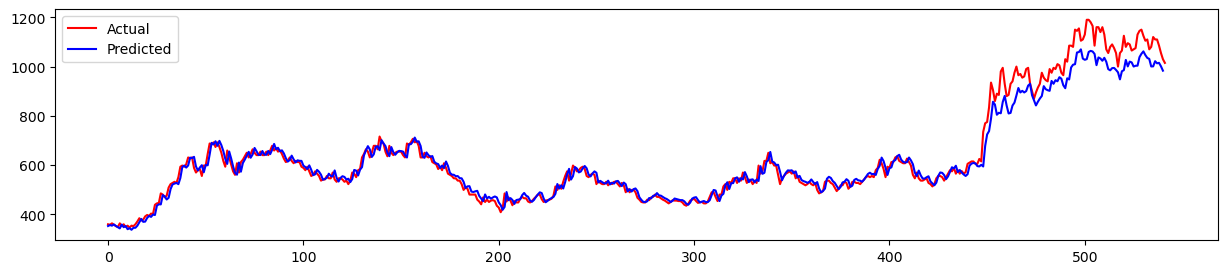

In [76]:
# Plot the actual and predicted log return values
plt.figure(figsize=(15, 3))  # Adjust the width and height as needed
plt.plot(fully_final['Adj Close'], label='Actual', color='red')
plt.plot(fully_final['Final Adj Close Pred'], label='Predicted', color='blue')
plt.legend()
plt.show()

#### Evaluation

In [77]:
# Drop rows with missing values
fully_final.dropna(inplace=True)

# Evaluation
import sklearn.metrics as metrics

y = fully_final['Adj Close']
yhat = fully_final['Final Adj Close Pred']
mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse)  # or mse**(0.5)
r2 = metrics.r2_score(y, yhat)

print("Results of sklearn.metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 26.033258801246966
MSE: 1628.0994135322353
RMSE: 40.34971392131839
R-Squared: 0.9593674955622818


### Conclusion

These results provide insights into the performance of each feature combination in predicting the Brent oil price. It appears that kv1 achieved the lowest MAE and RMSE, indicating better predictive performance compared to other combinations. However, further analysis and experimentation may be necessary to determine the most effective feature combination for accurate predictions.

* kv1 (Basic stock data with log returns):

    This combination includes only basic stock data such as open, close, high, low prices, along with the adjusted close price and log returns.
    It achieved the lowest MAE and RMSE among all combinations, indicating better predictive performance.
    The inclusion of log returns might have provided valuable information about the price movements, contributing to better predictions.

* kv2 (Stock data with technical indicators and log returns):

    In addition to the features in kv1, this combination includes technical indicators such as SMA_10, EMA_12, MACD, and RSI.
    While the addition of technical indicators could provide more insights into price trends and momentum, it resulted in slightly higher MAE and RMSE compared to kv1.
    Technical indicators might have introduced noise or redundancy in the data, impacting prediction accuracy.

* kv3 (Stock data with crude oil prices (WTI) and log returns):

    This combination includes crude oil prices (WTI) along with basic stock data and log returns.
    The inclusion of WTI crude oil prices might provide external factors affecting Brent oil prices.
    However, the higher MAE and RMSE suggest that WTI prices alone might not be sufficient for accurate predictions of Brent oil prices.

* kv4 (Stock data with technical indicators, WTI, and log returns):

    This combination includes all features from kv2 and kv3, along with WTI crude oil prices.
    Despite the inclusion of technical indicators and WTI prices, the performance metrics (MAE and RMSE) are closer to kv1 than kv2 or kv3.
    This suggests that while technical indicators and external factors like WTI prices provide additional information, their inclusion does not significantly improve prediction accuracy compared to basic stock data and log returns alone.